## Part 1


In [26]:
# imports
import wordcloud
from wordcloud import WordCloud
import json
from collections import defaultdict
from array import array
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jordi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jordi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# load data
import json, gzip
from pathlib import Path

def iter_json_objects(path):
    opener = gzip.open if str(path).endswith('.gz') else open
    with opener(path, 'rt', encoding='utf-8') as f:
        first = f.read(1)
        f.seek(0)
        if first == '[':
            try:
                import ijson
                for obj in ijson.items(f, 'item'):
                    yield obj
            except ImportError:
                data = json.load(f)
                for obj in data:
                    yield obj
        else:
            for line in f:
                line = line.strip()
                if line:
                    yield json.loads(line)

NOTEBOOK_DIR = Path().resolve()
DATA_PATH = NOTEBOOK_DIR.parents[1] / "data" / "fashion_products_dataset.json"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_PATH}. "
        "Please make sure 'fashion_products_dataset.json' is placed in the 'data/' folder at the repo root."
    )

print("Dataset path:", DATA_PATH)

records = list(iter_json_objects(DATA_PATH))
print(f"Loaded {len(records)} records successfully")

Dataset path: C:\Users\jordi\irwa-search-engine-g_019\data\fashion_products_dataset.json
Loaded 28080 records successfully


In [ ]:
# prep
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def to_number(x):
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).replace(",", "").strip().lower()
    if "% off" in s:
        s = s.split("%")[0]
    if s in ["true", "false"]:
        return 1.0 if s == "true" else 0.0
    try:
        return float(s)
    except ValueError:
        return np.nan

def details_to_text(details):
    if not details:
        return ""
    out = []
    for d in details:
        if isinstance(d, dict):
            for key, val in d.items():
                out.append(f"{key} {val}")
    return " ".join(out)

def process_product(prod):
    title = prod.get("title", "")
    desc = prod.get("description", "")
    dets = details_to_text(prod.get("product_details"))
    full_text = f"{title} {desc} {dets}"
    tokens = word_tokenize(full_text)
    tokens = [t.lower() for t in tokens if t.isalnum()]
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]
    clean_text = " ".join(tokens)
    return {
        "pid": prod.get("pid", ""),
        "title": title,
        "description": desc,
        "brand": prod.get("brand", ""),
        "category": prod.get("category", ""),
        "sub_category": prod.get("sub_category", ""),
        "product_details": prod.get("product_details", []),
        "seller": prod.get("seller", ""),
        "out_of_stock": to_number(prod.get("out_of_stock")),
        "selling_price": to_number(prod.get("selling_price")),
        "discount": to_number(prod.get("discount")),
        "actual_price": to_number(prod.get("actual_price")),
        "average_rating": to_number(prod.get("average_rating")),
        "url": prod.get("url", ""),
        "tokens": clean_text
    }

In [ ]:
# process data
processed_data = [process_product(rec) for rec in iter_json_objects(DATA_PATH)]
products_df = pd.DataFrame(processed_data)
products_df.set_index("pid", inplace=True)
products_df.head(4)

,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,url,tokens
pid,,,,,,,,,,,,,,
TKPFCZ9EA7H5FYZH,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO2'}, {'Closure': 'El...",Shyam Enterprises,0.0,921.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...
TKPFCZ9EJZV2UVRZ,Solid Men Blue Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005BLUE'}, {'Closure': 'Draw...",Shyam Enterprises,0.0,499.0,66.0,1499.0,3.9,https://www.flipkart.com/yorker-solid-men-blue...,solid men blue track pant yorker trackpant mad...
TKPFCZ9EHFCY5Z4Y,Solid Men Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO4'}, {'Closure': 'El...",Shyam Enterprises,0.0,931.0,68.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid men multicolor track pant yorker trackpa...
TKPFCZ9ESZZ7YWEF,Solid Women Multicolor Track Pants,Yorker trackpants made from 100% rich combed c...,York,Clothing and Accessories,Bottomwear,"[{'Style Code': '1005COMBO3'}, {'Closure': 'El...",Shyam Enterprises,0.0,911.0,69.0,2999.0,3.9,https://www.flipkart.com/yorker-solid-men-mult...,solid women multicolor track pant yorker track...


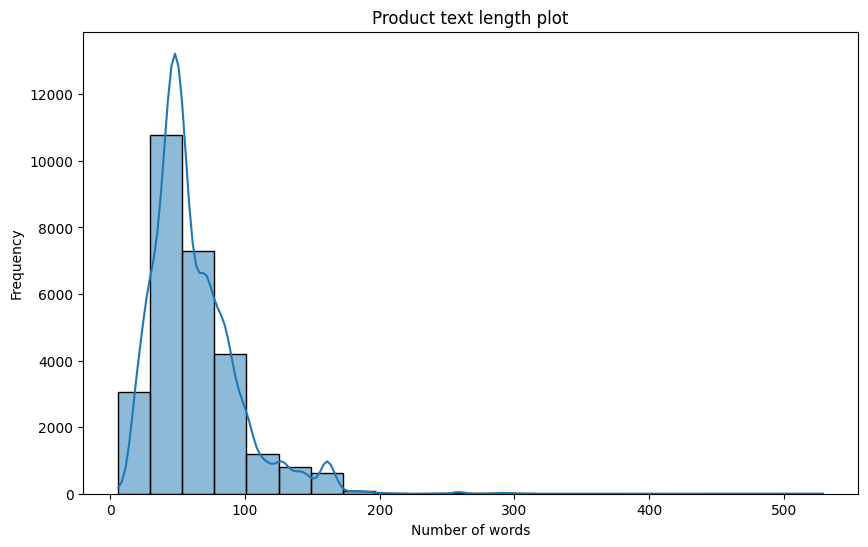

In [ ]:
# plot text length
vocab_df = products_df.copy()
vocab_df['Wordcount'] = products_df['tokens'].fillna('').apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(vocab_df['Wordcount'], bins=22, kde=True)
plt.title('Product text length plot')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# vocab info
whole_content = products_df['tokens'].fillna('').str.split().explode().tolist()
word_counts = Counter(whole_content)
vocab_dict = dict(word_counts)
print('Product vocabulary size is', len(vocab_dict))
sorted_dict = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
print('\nThe top 5 most appearing words are:')
for item in sorted_dict[:5]:
    print(item)

Product vocabulary size is 15877

The top 5 most appearing words are:
('fabric', 57213)
('neck', 56553)
('sleev', 50876)
('fit', 39523)
('type', 38701)


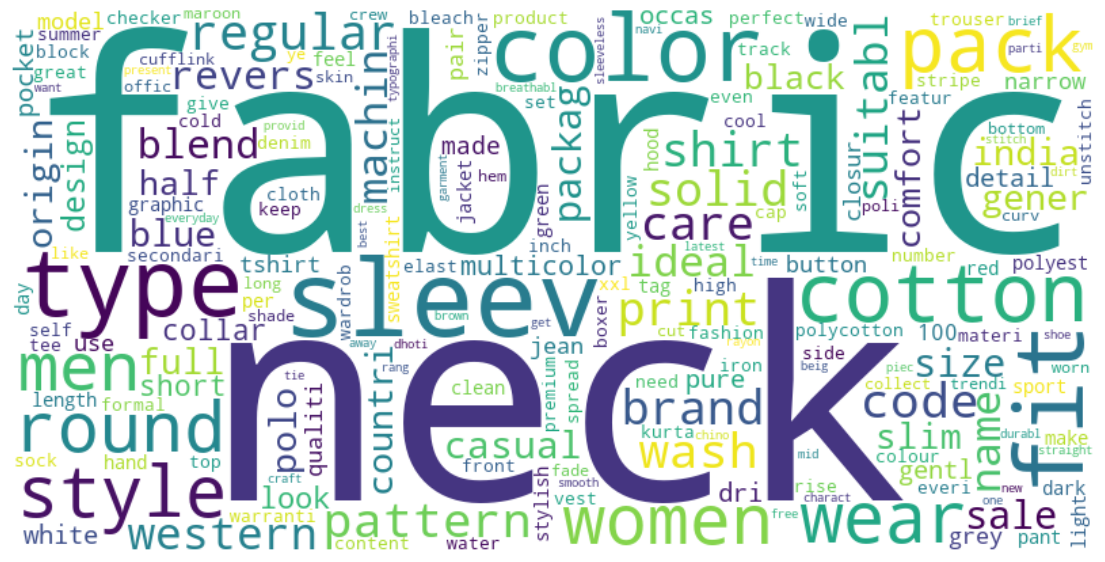

In [ ]:
# word cloud
words_wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocab_dict)
plt.figure(figsize=(14,8))
plt.imshow(words_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# top rated products
rated_df = products_df.copy()
rated_sorted = rated_df.sort_values(by='average_rating', ascending=False)
print('The following are the Top 5 Highest-Rated Products:')
rated_sorted.reset_index().drop(columns=['pid','url'], errors='ignore').head(5)

The following are the Top 5 Highest-Rated Products:


,title,description,brand,category,sub_category,product_details,seller,out_of_stock,selling_price,discount,actual_price,average_rating,tokens
0,Solid Women Round Neck Blue T-Shirt,,Oka,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Half Slee...",OKANE,0.0,385.0,44.0,699.0,5.0,solid women round neck blue type round neck sl...
1,Printed Women Hooded Neck Black T-Shirt,,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Hooded Neck'}, {'Sleeve': 'Full Sle...",ATTIITUDE,0.0,549.0,60.0,1399.0,5.0,print women hood neck black type hood neck sle...
2,Printed Women Hooded Neck Grey T-Shirt,,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Hooded Neck'}, {'Sleeve': 'Full Sle...",Assiduus Distribution,0.0,909.0,35.0,1399.0,5.0,print women hood neck grey type hood neck slee...
3,Graphic Print Men Round Neck Blue T-Shirt,,Free Authori,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Half Slee...",BioworldMerchandising,0.0,519.0,35.0,799.0,5.0,graphic print men round neck blue type round n...
4,"Solid Women Round Neck White, Black T-Shirt",Loosen up in this perfectlloose-fit black vest...,ATTIITU,Clothing and Accessories,Topwear,"[{'Type': 'Round Neck'}, {'Sleeve': 'Sleeveles...",Assiduus Distribution,0.0,649.0,35.0,999.0,5.0,solid women round neck white black loosen blac...


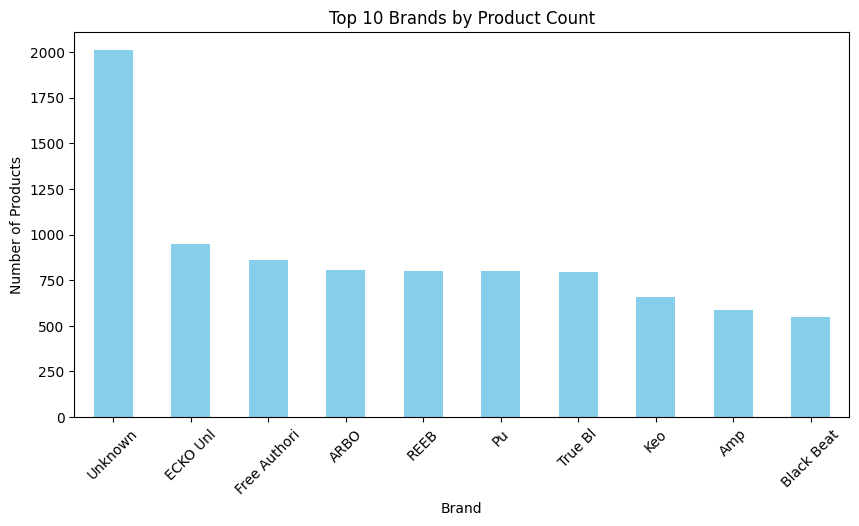

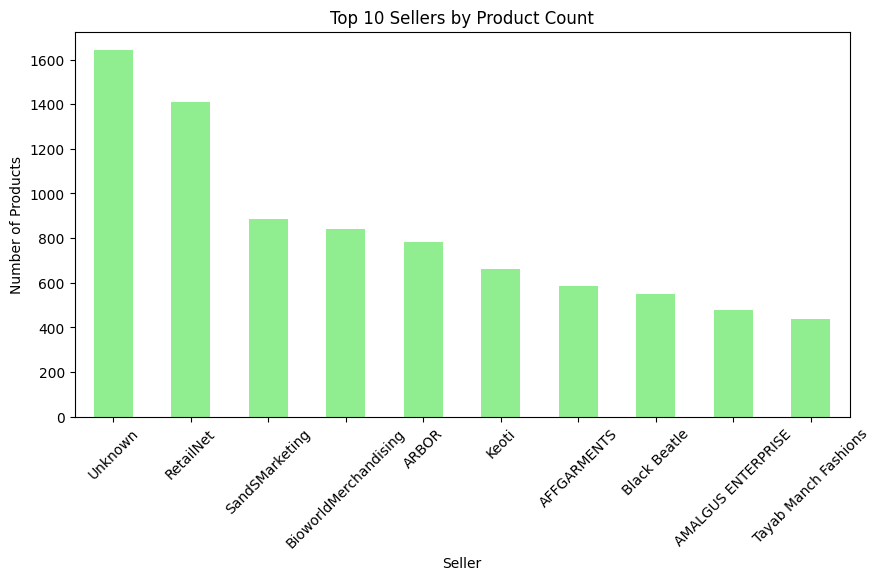

In [ ]:
# brands and sellers
products_df['brand'] = products_df['brand'].fillna('Unknown')
products_df['brand'] = products_df['brand'].replace('', 'Unknown')
top_brands = products_df['brand'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_brands.plot(kind='bar', color='skyblue')
plt.title('Top 10 Brands by Product Count')
plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()
products_df['seller'] = products_df['seller'].fillna('Unknown')
products_df['seller'] = products_df['seller'].replace('', 'Unknown')
top_sellers = products_df['seller'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_sellers.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Sellers by Product Count')
plt.xlabel('Seller')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.show()

## Part 2 — Indexing & Evaluation

In [ ]:
# search engine
TEXT_COL = "tokens_plus" if "tokens_plus" in products_df.columns else "tokens"
from collections import defaultdict, Counter
import math

docs = products_df[TEXT_COL].fillna("")
doc_ids = products_df.index.astype(str).tolist()
vocab = {}
postings = defaultdict(list)
df = Counter()
for pid, text in zip(doc_ids, docs):
    terms = text.split()
    if not terms:
        continue
    tf = Counter(terms)
    for t, f in tf.items():
        if t not in vocab:
            vocab[t] = len(vocab)
        df[t] += 1
        postings[t].append((pid, f))
N = len(doc_ids)
idf = {t: math.log((N + 1) / (df[t] + 1)) + 1.0 for t in df}
doc_norm = defaultdict(float)
for t, plist in postings.items():
    w_idf = idf[t]
    for pid, f in plist:
        w = (1 + math.log(f)) * w_idf
        doc_norm[pid] += w * w
for pid in list(doc_norm.keys()):
    doc_norm[pid] = math.sqrt(doc_norm[pid])
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
def preprocess_query(q):
    toks = word_tokenize(q)
    toks = [t.lower() for t in toks if t.isalnum()]
    toks = [stemmer.stem(t) for t in toks if t not in stop_words and len(t) > 2]
    return toks
def search_and_rank(query, top_k=20):
    q_terms = preprocess_query(query)
    if not q_terms:
        return []
    term_lists = []
    for t in q_terms:
        if t not in postings:
            return []
        term_lists.append(set(pid for pid, _ in postings[t]))
    cand = set.intersection(*term_lists) if term_lists else set()
    if not cand:
        return []
    q_tf = Counter(q_terms)
    q_weights = {}
    q_norm = 0.0
    for t, f in q_tf.items():
        w = (1 + math.log(f)) * idf.get(t, 0.0)
        q_weights[t] = w
        q_norm += w*w
    q_norm = math.sqrt(q_norm) if q_norm > 0 else 1.0
    scores = defaultdict(float)
    for t, wq in q_weights.items():
        for pid, f in postings.get(t, []):
            if pid not in cand:
                continue
            wd = (1 + math.log(f)) * idf.get(t, 0.0)
            scores[pid] += wq * wd
    ranked = []
    for pid, s in scores.items():
        dnorm = doc_norm.get(pid, 1.0)
        ranked.append((pid, s / (dnorm * q_norm if dnorm else 1.0)))
    ranked.sort(key=lambda x: x[1], reverse=True)
    out = products_df.loc[[pid for pid, _ in ranked[:top_k]], ["title","brand","category","url"]].copy()
    out.insert(0, "pid", [pid for pid,_ in ranked[:top_k]])
    out["score"] = [score for _, score in ranked[:top_k]]
    return out
# test
display(search_and_rank("women full sleeve sweatshirt cotton", top_k=10))

,pid,title,brand,category,url,score
pid,,,,,,
SWSF9W4TCKGPSSZZ,SWSF9W4TCKGPSSZZ,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.631933
SWSFYTYMNTBNARUN,SWSFYTYMNTBNARUN,Full Sleeve Solid Women Sweatshirt,ARBO,Clothing and Accessories,https://www.flipkart.com/arbour-full-sleeve-so...,0.627816
SWSFYFFFJZN6P6ZW,SWSFYFFFJZN6P6ZW,Full Sleeve Printed Women Sweatshirt,MASH UNLIMIT,Clothing and Accessories,https://www.flipkart.com/mash-unlimited-full-s...,0.622971
SWSF9W3ZHHJFQFJF,SWSF9W3ZHHJFQFJF,Full Sleeve Printed Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-pr...,0.610852
SWSFZAUYZFAGEPKK,SWSFZAUYZFAGEPKK,Full Sleeve Printed Women Sweatshirt,BLACK SN,Clothing and Accessories,https://www.flipkart.com/black-snow-full-sleev...,0.602448
SWSFVZRFS7GHGKSF,SWSFVZRFS7GHGKSF,Full Sleeve Solid Women Sweatshirt,RELIEF ZO,Clothing and Accessories,https://www.flipkart.com/relief-zone-full-slee...,0.601032
SWSF9W4TBFMF3GZA,SWSF9W4TBFMF3GZA,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.600254
SWSF9W4HABG6BBY4,SWSF9W4HABG6BBY4,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.594443
SWSF9W4TTB2M9ZXT,SWSF9W4TTB2M9ZXT,Full Sleeve Striped Women Sweatshirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-full-sleeve-st...,0.591259


In [ ]:
# frequent tokens
from collections import Counter
from random import sample
top_terms = Counter(" ".join(products_df[TEXT_COL].fillna("")).split()).most_common(200)
filtered = [t for t,_ in top_terms if t not in stop_words and len(t) > 3 and t not in {"size","color"}]
print(filtered[:20])

['fabric', 'neck', 'sleev', 'type', 'cotton', 'pack', 'style', 'wear', 'round', 'women', 'regular', 'pattern', 'wash', 'code', 'care', 'print', 'shirt', 'solid', 'brand', 'suitabl']


In [ ]:
# test queries
test_queries = [
    "women cotton shirt",
    "round neck shirt",
    "solid pattern wear",
    "men regular fit",
    "printed cotton fabric"
]
test_queries

['women cotton shirt',
 'round neck shirt',
 'solid pattern wear',
 'men regular fit',
 'printed cotton fabric']

In [ ]:
# run queries
for q in test_queries:
    print(f"\nQuery: {q}")
    display(search_and_rank(q, top_k=5))


Query: women cotton shirt


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTK76BEPJKDZ7,SHTFTK76BEPJKDZ7,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.437528
SHTFTJW9BUDMGUGV,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968
SHTFTJWAV7JGQHCB,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968
SHTFTJWB5PUSRMAC,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968
SHTFTJW9N7HR4Z5R,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.426968



Query: round neck shirt


,pid,title,brand,category,url,score
pid,,,,,,
TSHFW9CRK3GZDAGX,TSHFW9CRK3GZDAGX,Printed Men Round Neck Black T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.498467
TSHFW9CRBTZTKCGN,TSHFW9CRBTZTKCGN,Printed Men Round Neck White T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.489446
TSHFWZYBQPYSREDB,TSHFWZYBQPYSREDB,Solid Women Round Neck White T-Shirt,CA,Clothing and Accessories,https://www.flipkart.com/cara-solid-men-round-...,0.485436
TSHFW9CRFQCQCH4Q,TSHFW9CRFQCQCH4Q,Printed Women Round Neck Grey T-Shirt,Rose We,Clothing and Accessories,https://www.flipkart.com/rose-wear-printed-men...,0.484208
TSHEZP37J8S3SREJ,TSHEZP37J8S3SREJ,Solid Men Round Neck Black T-Shirt,HUMBE,Clothing and Accessories,https://www.flipkart.com/humbert-solid-men-rou...,0.478578



Query: solid pattern wear


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTJZ4XKAVFCNH,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.349782
SHTFTJZ4GZZYTFYN,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.349782
SHTFTJZ4RETDZMQH,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.347964
SHTFZSP23MASGF2Z,SHTFZSP23MASGF2Z,Women Regular Fit Solid Formal Shirt,PROLI,Clothing and Accessories,https://www.flipkart.com/prolife-men-solid-for...,0.344774
SHTFTJZ4AARXMGJ8,SHTFTJZ4AARXMGJ8,Men Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-solid-casu...,0.343878



Query: men regular fit


,pid,title,brand,category,url,score
pid,,,,,,
TSHFN6QANCZHVQZB,TSHFN6QANCZHVQZB,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-solid-men-roun...,0.422367
TSHF2DZ6YS662GFQ,TSHF2DZ6YS662GFQ,Solid Men V-neck White T-Shirt,rockha,Clothing and Accessories,https://www.flipkart.com/rockhard-solid-men-v-...,0.419115
SHTFNFWCK6AK9J7G,SHTFNFWCK6AK9J7G,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories,https://www.flipkart.com/allan-peter-men-print...,0.411593
SHTFNFTFZBYNCT5E,SHTFNFTFZBYNCT5E,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories,https://www.flipkart.com/allan-peter-men-print...,0.411593
TSHFN6QA9RZDMFGS,TSHFN6QA9RZDMFGS,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories,https://www.flipkart.com/axmann-solid-men-roun...,0.410053



Query: printed cotton fabric


,pid,title,brand,category,url,score
pid,,,,,,
SHTFTJW9BUDMGUGV,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJWAV7JGQHCB,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJWB5PUSRMAC,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJW9N7HR4Z5R,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427697
SHTFTJWCPVTWGBYW,SHTFTJWCPVTWGBYW,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories,https://www.flipkart.com/sorang-men-printed-ca...,0.427559


In [ ]:
# metrics
def precision_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / float(k)
def recall_at_k(y_true, y_pred, k=10):
    pred = y_pred[:k]
    rel_total = sum(y_true.values())
    hits = sum(y_true.get(pid, 0) for pid in pred)
    return hits / max(1, rel_total)
def ap_at_k(y_true, y_pred, k=10):
    ap, hits = 0.0, 0
    for i, pid in enumerate(y_pred[:k], start=1):
        if y_true.get(pid, 0):
            hits += 1
            ap += hits / i
    rel_total = sum(y_true.values())
    return ap / max(1, min(rel_total, k))
def f1_at_k(y_true, y_pred, k=10):
    p = precision_at_k(y_true, y_pred, k)
    r = recall_at_k(y_true, y_pred, k)
    return 2*p*r / (p + r) if (p+r) > 0 else 0.0
def map_score(list_of_labeldicts, list_of_rankings, k=10):
    aps = [ap_at_k(y_true, y_pred, k) for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings)]
    return float(np.mean(aps)) if aps else 0.0
def mrr(list_of_labeldicts, list_of_rankings, k=10):
    rr = []
    for y_true, y_pred in zip(list_of_labeldicts, list_of_rankings):
        rank = None
        for i, pid in enumerate(y_pred[:k], start=1):
            if y_true.get(pid, 0):
                rank = i; break
        rr.append(1.0/rank if rank else 0.0)
    return float(np.mean(rr)) if rr else 0.0
def ndcg_at_k(y_true, y_pred, k=10):
    gains = [y_true.get(pid, 0) for pid in y_pred[:k]]
    dcg = sum(g / math.log2(i+2) for i, g in enumerate(gains))
    ideal_gains = sorted(y_true.values(), reverse=True)[:k]
    idcg = sum(g / math.log2(i+2) for i, g in enumerate(ideal_gains))
    return dcg / idcg if idcg > 0 else 0.0

In [ ]:
# eval
val = pd.read_csv("../../data/validation_labels.csv")
val["pid"] = val["pid"].astype(str)
predef_queries = {
    1: "women full sleeve sweatshirt cotton",
    2: "men slim jeans blue",
}
K = 10
metric_table = []
all_labeldicts, all_rankings = [], []
for qid, qtext in predef_queries.items():
    sub = val[val["query_id"] == qid].copy()
    labeldict = dict(zip(sub["pid"], sub["labels"]))
    ranked_df = search_and_rank(qtext, top_k=len(sub))
    ranked_pids = [pid for pid in ranked_df["pid"].tolist() if pid in labeldict]
    tail = [pid for pid in sub["pid"].tolist() if pid not in set(ranked_pids)]
    final_order = ranked_pids + tail
    P = precision_at_k(labeldict, final_order, K)
    R = recall_at_k(labeldict, final_order, K)
    AP = ap_at_k(labeldict, final_order, K)
    F1 = f1_at_k(labeldict, final_order, K)
    N = ndcg_at_k(labeldict, final_order, K)
    metric_table.append([qid, P, R, AP, F1, N])
    all_labeldicts.append(labeldict)
    all_rankings.append(final_order)
MAP = map_score(all_labeldicts, all_rankings, K)
MRR = mrr(all_labeldicts, all_rankings, K)
for row in metric_table:
    qid, P, R, AP, F1, N = row
    print(f"{qid} {P:.3f} {R:.3f} {AP:.3f} {F1:.3f} {N:.3f}")
print(f"MAP {MAP:.3f}")
print(f"MRR {MRR:.3f}")

1 0.700 0.538 0.508 0.609 0.703
2 0.600 0.600 0.473 0.600 0.665
MAP 0.490
MRR 1.000


In [ ]:
# helpers
def evaluate_labeled_query(results_df, rel_idx, k=10):
    ranking, y_true = finalize_labels(results_df, rel_idx)
    P  = precision_at_k(y_true, ranking, k)
    R  = recall_at_k(y_true, ranking, k)
    AP = ap_at_k(y_true, ranking, k)
    F1 = f1_at_k(y_true, ranking, k)
    N  = ndcg_at_k(y_true, ranking, k)
    print(f"P@{k}={P:.3f} R@{k}={R:.3f} AP@{k}={AP:.3f} F1@{k}={F1:.3f} NDCG@{k}={N:.3f}")
    return ranking, y_true

def label_query_noinput(q, top_k=30):
    df = search_and_rank(q, top_k=top_k).reset_index(drop=True)
    df.insert(0, "idx", range(len(df)))
    display(df[["idx","pid","title","brand","category"]])
    print("\nSet rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}\nThen run: ranking, y_true = finalize_labels(df, rel_idx)")
    return df

def finalize_labels(df, rel_idx):
    rel_pids = set(df.loc[list(rel_idx), "pid"])
    y_true = {pid: (pid in rel_pids) for pid in df["pid"].tolist()}
    ranking = df["pid"].tolist()
    return ranking, y_true

In [ ]:
def run_one_query(q, rel_idx, k=10):
    df = label_query_noinput(q, top_k=30)
    ranking, y_true = evaluate_labeled_query(df, rel_idx, k=k)
    print("Relevant PIDs:", [df.loc[i, "pid"] for i in sorted(rel_idx)])
    print("Top-10 ranking PIDs:", ranking[:10])
    return df, ranking, y_true
# example
df, ranking, y_true = run_one_query("men slim jeans blue", {0, 1}, k=10)

,idx,pid,title,brand,category
0,0,JEAFVDRJZ5RWAFHB,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
1,1,JEAFVPFUA97ZETDB,Slim Men Blue Jeans,TimeO,Clothing and Accessories
2,2,JEAFV8WURBM7PGYT,Slim Men Blue Jeans,Reliable Ca,Clothing and Accessories
3,3,JEAFSKYHZHSZZC9S,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
4,4,JEAFRAQXEKGUPNUN,Slim Men Blue Jeans,Lev,Clothing and Accessories
5,5,JEAFSKYHRVZSABPR,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
6,6,JEAFSKYHTE76YWH7,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
7,7,JEAFQF6JBUSEXHVF,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
8,8,JEAFSKYHSYMTKEJD,Slim Men Blue Jeans,ECKO Unl,Clothing and Accessories
9,9,JEAEVJGUSXRNSHRY,Slim Men Dark Blue Jeans,Absolu,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.200 R@10=1.000 AP@10=1.000 F1@10=0.333 NDCG@10=1.000
Relevant PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFVPFUA97ZETDB']
Top-10 ranking PIDs: ['JEAFVDRJZ5RWAFHB', 'JEAFVPFUA97ZETDB', 'JEAFV8WURBM7PGYT', 'JEAFSKYHZHSZZC9S', 'JEAFRAQXEKGUPNUN', 'JEAFSKYHRVZSABPR', 'JEAFSKYHTE76YWH7', 'JEAFQF6JBUSEXHVF', 'JEAFSKYHSYMTKEJD', 'JEAEVJGUSXRNSHRY']


In [43]:
df_ws, ranking_ws, y_true_ws = run_one_query("women cotton shirt", {}, k=10)

,idx,pid,title,brand,category
0,0,SHTFTK76BEPJKDZ7,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
4,4,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
5,5,SHTFAHEYNJFTZDNN,Women Regular Fit Solid Casual Shirt,Purple Sta,Clothing and Accessories
6,6,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
7,7,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
8,8,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
9,9,TSHFWAJEA5XG3NUP,Solid Women V Neck Black T-Shirt,Rose We,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTK76BEPJKDZ7', 'SHTFTJW9BUDMGUGV', 'SHTFTJWAV7JGQHCB', 'SHTFTJWB5PUSRMAC', 'SHTFTJW9N7HR4Z5R', 'SHTFAHEYNJFTZDNN', 'SHTFTJZ4XKAVFCNH', 'SHTFTJZ4GZZYTFYN', 'SHTFTJZ4RETDZMQH', 'TSHFWAJEA5XG3NUP']


In [44]:
df_hf, ranking_hf, y_true_hf = run_one_query("round neck shirt", {1,2,3,4,5}, k=10)

,idx,pid,title,brand,category
0,0,TSHFW9CRK3GZDAGX,Printed Men Round Neck Black T-Shirt,Rose We,Clothing and Accessories
1,1,TSHFW9CRBTZTKCGN,Printed Men Round Neck White T-Shirt,Rose We,Clothing and Accessories
2,2,TSHFWZYBQPYSREDB,Solid Women Round Neck White T-Shirt,CA,Clothing and Accessories
3,3,TSHFW9CRFQCQCH4Q,Printed Women Round Neck Grey T-Shirt,Rose We,Clothing and Accessories
4,4,TSHEZP37J8S3SREJ,Solid Men Round Neck Black T-Shirt,HUMBE,Clothing and Accessories
5,5,TSHFWZYS9NYE7CKM,Solid Men Round Neck White T-Shirt,CA,Clothing and Accessories
6,6,TSHFW9CRKKYZHQB4,Printed Women Round Neck Green T-Shirt,Rose We,Clothing and Accessories
7,7,TSHEZP36HTH9TUTR,Solid Men Round Neck White T-Shirt,HUMBE,Clothing and Accessories
8,8,TSHFW9CJYKXB3NKD,Printed Women Round Neck Black T-Shirt,Rose We,Clothing and Accessories
9,9,TSHFZZRSPUF3NQYM,Printed Women Round Neck Black T-Shirt,Styleska,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.500 R@10=1.000 AP@10=0.710 F1@10=0.667 NDCG@10=0.782
Relevant PIDs: ['TSHFW9CRBTZTKCGN', 'TSHFWZYBQPYSREDB', 'TSHFW9CRFQCQCH4Q', 'TSHEZP37J8S3SREJ', 'TSHFWZYS9NYE7CKM']
Top-10 ranking PIDs: ['TSHFW9CRK3GZDAGX', 'TSHFW9CRBTZTKCGN', 'TSHFWZYBQPYSREDB', 'TSHFW9CRFQCQCH4Q', 'TSHEZP37J8S3SREJ', 'TSHFWZYS9NYE7CKM', 'TSHFW9CRKKYZHQB4', 'TSHEZP36HTH9TUTR', 'TSHFW9CJYKXB3NKD', 'TSHFZZRSPUF3NQYM']


In [45]:
df_fd, ranking_fd, y_true_fd = run_one_query("solid pattern regular wear", { }, k=10)

,idx,pid,title,brand,category
0,0,SHTFTJZ4XKAVFCNH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJZ4GZZYTFYN,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJZ4RETDZMQH,Women Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFZSP23MASGF2Z,Women Regular Fit Solid Formal Shirt,PROLI,Clothing and Accessories
4,4,SHTFTJZ4AARXMGJ8,Men Regular Fit Solid Casual Shirt,SORA,Clothing and Accessories
5,5,SHTF7Y285HFZGEVW,Women Regular Fit Solid Casual Shirt,Purple Sta,Clothing and Accessories
6,6,SHTFYKWT6HU8NWH5,Men Regular Fit Solid Formal Shirt,NEXXE,Clothing and Accessories
7,7,SHTFNYZFHPFHZHPM,Women Regular Fit Solid Formal Shirt,R,Clothing and Accessories
8,8,SHTFZZ86XKJ2GJYV,Women Regular Fit Solid Casual Shirt,ARBO,Clothing and Accessories
9,9,TSHEHG2922TRGAFA,Solid Women V-neck White T-Shirt,The Arch,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTJZ4XKAVFCNH', 'SHTFTJZ4GZZYTFYN', 'SHTFTJZ4RETDZMQH', 'SHTFZSP23MASGF2Z', 'SHTFTJZ4AARXMGJ8', 'SHTF7Y285HFZGEVW', 'SHTFYKWT6HU8NWH5', 'SHTFNYZFHPFHZHPM', 'SHTFZZ86XKJ2GJYV', 'TSHEHG2922TRGAFA']


In [46]:
df_rs, ranking_rs, y_true_rs = run_one_query("men regular fit", { 3,4}, k=10)

,idx,pid,title,brand,category
0,0,TSHFN6QANCZHVQZB,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
1,1,TSHF2DZ6YS662GFQ,Solid Men V-neck White T-Shirt,rockha,Clothing and Accessories
2,2,SHTFNFWCK6AK9J7G,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
3,3,SHTFNFTFZBYNCT5E,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
4,4,TSHFN6QA9RZDMFGS,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
5,5,TSHFN6QAHTJ523ZR,Solid Men Round Neck Blue T-Shirt,AXMA,Clothing and Accessories
6,6,SHTFNFUHGVYGRZFV,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
7,7,SHTFWAP5WUVXS3PQ,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
8,8,SHTFNFSGN62XZCYR,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories
9,9,SHTFNFWNAUBYHWXU,Men Regular Fit Printed Casual Shirt,allan pet,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.200 R@10=1.000 AP@10=0.325 F1@10=0.333 NDCG@10=0.501
Relevant PIDs: ['SHTFNFTFZBYNCT5E', 'TSHFN6QA9RZDMFGS']
Top-10 ranking PIDs: ['TSHFN6QANCZHVQZB', 'TSHF2DZ6YS662GFQ', 'SHTFNFWCK6AK9J7G', 'SHTFNFTFZBYNCT5E', 'TSHFN6QA9RZDMFGS', 'TSHFN6QAHTJ523ZR', 'SHTFNFUHGVYGRZFV', 'SHTFWAP5WUVXS3PQ', 'SHTFNFSGN62XZCYR', 'SHTFNFWNAUBYHWXU']


In [50]:
df_rs, ranking_rs, y_true_rs = run_one_query("printed cotton fabric", {}, k=10)

,idx,pid,title,brand,category
0,0,SHTFTJW9BUDMGUGV,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
1,1,SHTFTJWAV7JGQHCB,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
2,2,SHTFTJWB5PUSRMAC,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
3,3,SHTFTJW9N7HR4Z5R,Women Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
4,4,SHTFTJWCPVTWGBYW,Men Regular Fit Printed Casual Shirt,SORA,Clothing and Accessories
5,5,SHTFJZC2ZHMEUFVT,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
6,6,SHTFJZC26VXWPAR3,Men Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
7,7,SHTFJZC4GJ7Q8MUM,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
8,8,SHTFJZC2TXC9CHPH,Women Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories
9,9,SHTFJZCYHHMYEJAW,Men Slim Fit Printed Casual Shirt,SUR,Clothing and Accessories



Set rel_idx in the NEXT cell, e.g.:  rel_idx = {0, 2, 5}
Then run: ranking, y_true = finalize_labels(df, rel_idx)
P@10=0.000 R@10=0.000 AP@10=0.000 F1@10=0.000 NDCG@10=0.000
Relevant PIDs: []
Top-10 ranking PIDs: ['SHTFTJW9BUDMGUGV', 'SHTFTJWAV7JGQHCB', 'SHTFTJWB5PUSRMAC', 'SHTFTJW9N7HR4Z5R', 'SHTFTJWCPVTWGBYW', 'SHTFJZC2ZHMEUFVT', 'SHTFJZC26VXWPAR3', 'SHTFJZC4GJ7Q8MUM', 'SHTFJZC2TXC9CHPH', 'SHTFJZCYHHMYEJAW']
